# Tomato disease detection

## Research topic
The aim of this project is to build a model for identifying tomato plant diseases. This will be done from a dataset covering 9 different diseases and healthy leaves. Both Support Vector Machines (SVMs) and Convolutional Neural Networks (CNNs) will be used, and then methods used to attempt to improve upon initial models.

## Dataset

The data is sourced from [Data for: Identification of Plant Leaf Diseases Using a 9-layer Deep Convolutional Neural Network](https://data.mendeley.com/datasets/tywbtsjrjv/1). The original dataset covers a variety of different plants and diseases which were used for [Identification of plant leaf diseases using a nine-layer deep convolutional neural network](https://www.sciencedirect.com/science/article/abs/pii/S0045790619300023?via%3Dihub). Versions of the dataset both with and without augmentation are provided.

The subset used here covers only tomato plant leaves. This is still a fairly extensive dataset because a total of 9 diseases are labelled within the images. The images without augmentation are used since otherwise they may appear in the test data. The categories aren't equally balances; the Tomato Mosaic Virus has 373 images to the 5357 for the Tomato Yellow Leaf Curl Virus. 

<a id='contents'></a>
## Contents

1. [Data preparation](#data_prep)
2. [Support Vector Machines](#svm)
3. [Convolutional Neural Networks](#cnn)
4. [Summary](#summary)

## Packages and set up

In [1]:
# General
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import splitfolders
import random
import re
import itertools
import shutil
import math

# Images
from keras.preprocessing import image
from PIL import Image

# Models
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import keras
from keras.models import Sequential, load_model, Model
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, BatchNormalization, Reshape, UpSampling2D
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import optimizers
import keras_tuner

# Evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

# Custom functions
from utils import print_sf_no, print_sf2_no, print_img_size_check, img_resize_all, plot_confusion_matrix, eval_plot

2023-04-13 10:45:32.448524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from numpy.random import seed
seed(765)

<a id='data_prep'></a>
## Data preparation
[Back to contents](#contents)

The data is not yet split into training, validation and test sets. It is currently stored with a separate folder for each disease category within 'raw_images'. Each category has a different number of images.

### Number of images

In [3]:
print_sf_no('raw_images') # Function stored in utils

Target_Spot 1404
Late_blight 1909
Tomato_mosaic_virus 373
Leaf_Mold 952
Bacterial_spot 2127
Early_blight 1000
healthy 1591
Tomato_Yellow_Leaf_Curl_Virus 5357
Spider_mites Two-spotted_spider_mite 1676
Septoria_leaf_spot 1771
Total 18160


The publishers of the dataset also released a dataset with augmentation of the number of images for the smallest categories (Tomato Mosaic Virus and Leaf Mold). However, as the training/testing split they used is not released, using this would mean that some of the augmented images could be in the test set with the original in the training. This would make the model appear to perform better than in reality. As such, the original dataset has been used.

It would be possible to perform augmentation on the training and validation data after the split has been made. However the number of images is already pushing the computational powers of my machine so more images is not helpful.

### Image size

Some processing might be needed of the images themselves to ensure they are a suitable size and have been normalised etc.

Beginning by looking at an individual image:

Dimensions: (256, 256, 3)


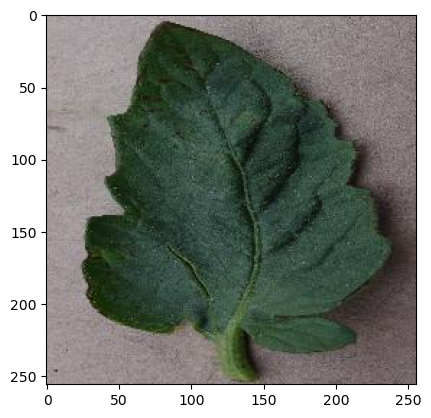

In [4]:
img = Image.open("raw_images/Tomato___Bacterial_spot/image (1).JPG")
img_array = np.asarray(img)
plt.imshow(img)
print("Dimensions:",img_array.shape)

This image is already a suitable size for machine learning. The next step is to check that all of the other images are the same size.

In [5]:
print_img_size_check('raw_images', (256,256,3)) # Function stored in utils

Target_Spot
Images of other sizes: 0
---
Late_blight
Images of other sizes: 0
---
Tomato_mosaic_virus
Images of other sizes: 0
---
Leaf_Mold
Images of other sizes: 0
---
Bacterial_spot
Images of other sizes: 0
---
Early_blight
Images of other sizes: 0
---
healthy
Images of other sizes: 0
---
Tomato_Yellow_Leaf_Curl_Virus
Images of other sizes: 0
---
Spider_mites Two-spotted_spider_mite
Images of other sizes: 0
---
Septoria_leaf_spot
Images of other sizes: 0
---
Other image dimensions: []


All of the images are already the same dimensions, and these are suitable for using for machine learning. So no resizing is needed.

### Training/validation/testing split

The data needs to be split into training, validation and testing. Of the 18,160 images, 70% will be allocated for training, 20% for validation and 10% for testing. This will be done using [split-folders](https://pypi.org/project/split-folders/). After the split, the images for each category are still stored in separate folders eg. healthy, Leaf_Mold etc. within each of train, test and val.

In [6]:
splitfolders.ratio("raw_images", output="split_images",  
                   ratio=(.7, .2, .1), group_prefix=None, move=False)

Copying files: 18160 files [00:06, 2767.38 files/s]


In [7]:
print_sf2_no('split_images') # Function stored in utils

test
Target_Spot 142
Late_blight 192
Tomato_mosaic_virus 38
Leaf_Mold 96
Bacterial_spot 214
Early_blight 100
healthy 160
Tomato_Yellow_Leaf_Curl_Virus 537
Spider_mites Two-spotted_spider_mite 168
Septoria_leaf_spot 178
Total 1825
---
train
Target_Spot 982
Late_blight 1336
Tomato_mosaic_virus 261
Leaf_Mold 666
Bacterial_spot 1488
Early_blight 700
healthy 1113
Tomato_Yellow_Leaf_Curl_Virus 3749
Spider_mites Two-spotted_spider_mite 1173
Septoria_leaf_spot 1239
Total 12707
---
val
Target_Spot 280
Late_blight 381
Tomato_mosaic_virus 74
Leaf_Mold 190
Bacterial_spot 425
Early_blight 200
healthy 318
Tomato_Yellow_Leaf_Curl_Virus 1071
Spider_mites Two-spotted_spider_mite 335
Septoria_leaf_spot 354
Total 3628
---


### Subset for manageable processing

This is too many images for efficiently training models on my computer. The kernel dies when trying to train SVMs and it is impractical to carry out hyperparameter tuning. It is still reasonable to use the full testing dataset all of the time, but a smaller subset of the training and validation data will be used for some aspects. This subset is 20 times smaller.

In [8]:
for folder_name in ['train', 'val']:
    # Removing the file if already there
    if os.path.isdir('./subset/'+folder_name+'/'):
        shutil.rmtree('./subset/'+folder_name+'/')
        os.makedirs('./subset/'+folder_name+'/')
    
    # Listing all images, and then keeping a 20th of the images
    dir_list = next(os.walk('./split_images/'+folder_name))[1]
    for folder in dir_list:
        os.makedirs('./subset/'+folder_name+'/'+folder+'/')
        img_list = next(os.walk('./split_images/'+folder_name+'/'+folder+"/"))[2]
        img_list_new = random.sample(img_list, k=math.ceil(len(img_list)/20))
        for images in img_list_new:
            shutil.copy('./split_images/'+folder_name+'/'+folder+'/'+images,
                        './subset/'+folder_name+'/'+folder+'/'+images)

print_sf2_no('subset') # Function stored in utils           

train
Target_Spot 50
Late_blight 67
Tomato_mosaic_virus 14
Leaf_Mold 34
Bacterial_spot 75
Early_blight 35
healthy 56
Tomato_Yellow_Leaf_Curl_Virus 188
Spider_mites Two-spotted_spider_mite 59
Septoria_leaf_spot 62
Total 640
---
val
Target_Spot 14
Late_blight 20
Tomato_mosaic_virus 4
Leaf_Mold 10
Bacterial_spot 22
Early_blight 10
healthy 16
Tomato_Yellow_Leaf_Curl_Virus 54
Spider_mites Two-spotted_spider_mite 17
Septoria_leaf_spot 18
Total 185
---


<a id='svm'></a>
## Support Vector Machines
[Back to contents](#contents)

Before looking at CNNs for the task, Support Vector Machines should provide a significant improvement on randomly guessing the category. For random guesses, the best approach would be to always select Tomato Yellow Leaf Curl Virus and this would be correct approximately 30% of the time.

First a function is defined for reading in the images, normalising them and flattening the array. The smaller subset is used for training and validation. SVMs are fairly memory heavy whilst being produced due to the number of comparisons that must be made.

The order of the images for training shouldn't matter for an SVM so the order is not shuffled.

In [9]:
def svm_load(folder_name):
    images = []
    labels = []
    dir_list = next(os.walk('./'+folder_name))[1]
    
    for folder in dir_list:
        img_list = next(os.walk('./'+folder_name+'/'+folder+'/'))[2]
        
        for imag in img_list:
            img = load_img('./'+folder_name+'/'+folder+'/'+imag, target_size=(256, 256,3))
            img = img_to_array(img)
            img = img/255
            images.append(img.flatten())
            labels.append(folder)
            
    return(images, labels)

In [10]:
train_data, train_labels = svm_load('./subset/train')
valid_data, valid_labels = svm_load('./subset/val')
test_data, test_labels = svm_load('./split_images/test')

### Basic SVM

Now a basic SVM can be trained on the data.

In [11]:
model = svm.SVC()
model.fit(train_data, train_labels)

SVC()

In [12]:
test_predict = model.predict(test_data)

/Users/abigailhayes/opt/anaconda3/envs/AI_FSS23/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/abigailhayes/opt/anaconda3/envs/AI_FSS23/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/abigailhayes/opt/anaconda3/envs/AI_FSS23/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.73      0.63      0.68       214
                        Tomato___Early_blight       0.60      0.03      0.06       100
                         Tomato___Late_blight       0.46      0.62      0.53       192
                           Tomato___Leaf_Mold       0.84      0.45      0.59        96
                  Tomato___Septoria_leaf_spot       0.56      0.50      0.53       178
Tomato___Spider_mites Two-spotted_spider_mite       0.50      0.56      0.53       168
                         Tomato___Target_Spot       0.40      0.48      0.44       142
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.71      0.94      0.81       537
                 Tomato___Tomato_mosaic_virus       0.00      0.00      0.00        38
                             Tomato___healthy       0.83      0.47      0.60       160

                                     accu

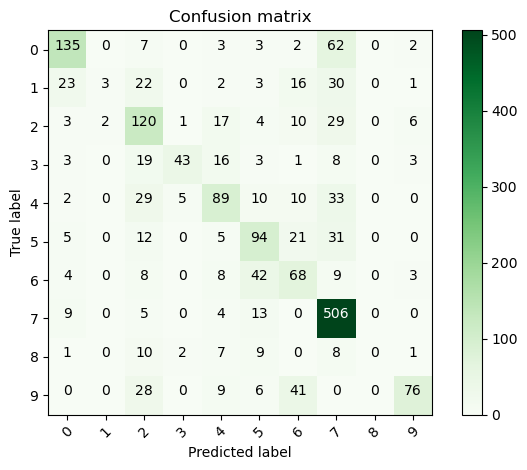

In [13]:
print(classification_report(test_labels, test_predict))
plot_confusion_matrix(confusion_matrix(test_labels, test_predict), classes=range(10))

Even with a basic SVM trained on a reduced dataset, these results represent a significant improvement over randomly guessing. The results appear to be very heavily influenced by the number of images included for each of the categories; Tomato Yellow Leaf Curl Virus is the largest and has significantly better results, whilst Tomato Mosaic Virus images are always assigned to the other categories. This is to be expected as the system should work best for that which it receives the most data for, and can be seen in the scatter plot below.

In [14]:
cat_count = {}
correct_count = {}

for i in range(len(test_labels)):
    if test_labels[i] not in cat_count:
        cat_count[test_labels[i]] = 0
        correct_count[test_labels[i]] = 0
    cat_count[test_labels[i]] += 1
    if test_labels[i]==test_predict[i]:
        correct_count[test_labels[i]] += 1
        
train_count = {}

for i in range(len(train_data)):
    if train_labels[i] not in train_count:
        train_count[train_labels[i]] = 0
    train_count[train_labels[i]] +=1

In [15]:
cat_prop = []
cat_counts = []
cat_lab = []

for i in cat_count:
    cat_prop.append(correct_count[i]/cat_count[i])
    cat_counts.append(train_count[i])
    cat_lab.append(i)

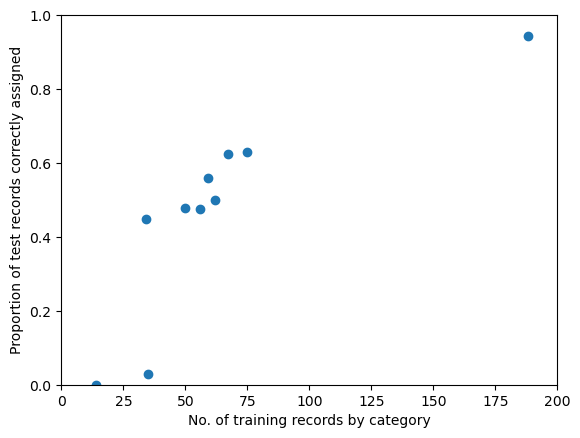

In [16]:
plt.scatter(cat_counts, cat_prop)

plt.xlabel('No. of training records by category')
plt.ylabel('Proportion of test records correctly assigned')

plt.xlim([0, 200])
plt.ylim([0,1])

plt.show()

### Rebalanced SVM

It is not clear that the number of images in each category actually represents some proportion from the real world. In fact, it is probably reasonable to assume that a plant is not 3 times more likely to have Tomato Yellow Leaf Curl Virus that to be healthy. As a comparison, try using 64 from each category to give  similar sized dataset but with equal images for each category. This is likely to reduce the overall results because the biggest category is still most represented in the test data. 

In [17]:
def svm_load_no(folder_name, number):
    images = []
    labels = []
    dir_list = next(os.walk('./'+folder_name))[1]
    
    for folder in dir_list:
        img_list = next(os.walk('./'+folder_name+'/'+folder+'/'))[2]
        img_list2 = random.sample(img_list, number)
        
        for imag in img_list2:
            img = load_img('./'+folder_name+'/'+folder+'/'+imag, target_size=(256, 256,3))
            img = img_to_array(img)
            img = img/255
            images.append(img.flatten())
            labels.append(folder)
            
    return(images, labels)

In [18]:
train_data_new, train_labels_new = svm_load_no('./split_images/train', 64)

In [19]:
model_new = svm.SVC()
model_new.fit(train_data_new, train_labels_new)

SVC()

In [20]:
test_predict_new = model_new.predict(test_data)

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.59      0.76      0.66       214
                        Tomato___Early_blight       0.27      0.42      0.33       100
                         Tomato___Late_blight       0.62      0.42      0.50       192
                           Tomato___Leaf_Mold       0.55      0.50      0.52        96
                  Tomato___Septoria_leaf_spot       0.52      0.42      0.47       178
Tomato___Spider_mites Two-spotted_spider_mite       0.50      0.59      0.54       168
                         Tomato___Target_Spot       0.50      0.51      0.51       142
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.89      0.66      0.75       537
                 Tomato___Tomato_mosaic_virus       0.23      0.68      0.34        38
                             Tomato___healthy       0.72      0.82      0.76       160

                                     accu

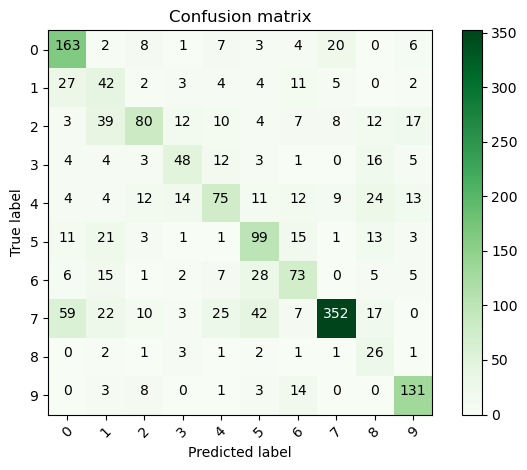

In [21]:
print(classification_report(test_labels, test_predict_new))
plot_confusion_matrix(confusion_matrix(test_labels, test_predict_new), classes=range(10))

The results haven't changed very much. The best and worst classified categories remain pretty much the same. Early Blight still has many images classified elsewhere, and a lot of other images missclassified to it.

There aren't clear groups that are getting mis-classified to each other. ie. 1 often missclassified as 0 but not the reverse. Perhaps the exceptions to this might be the pairs of 1/2 (Early/Late Blight) and 5/6 (Two-spotted spider mite and Target Spot).

### Polynomial SVMs

SVMs can also be constructed with higher degree polynomials. Versions with degree from 2 to 6 are built here using the original data subset.

In [22]:
svm_poly = []
svm_poly_pred = []

for i in range(2,6):
    model = svm.SVC(kernel="poly", degree=i)
    model.fit(train_data, train_labels)
    svm_poly.append(model)
    svm_poly_pred.append(model.predict(test_data))
    print("Polynomial SVM of degree ", i, " finished")

Polynomial SVM of degree  2  finished
Polynomial SVM of degree  3  finished
Polynomial SVM of degree  4  finished
Polynomial SVM of degree  5  finished


In [23]:
for i in range(4):
    print("Degree ", i+2, ":")
    print("Accuracy - ",metrics.accuracy_score(test_labels, svm_poly_pred[i]))
    print("F1 - ",metrics.f1_score(test_labels, svm_poly_pred[i], average='weighted'))
    print("")

Degree  2 :
Accuracy -  0.6317808219178083
F1 -  0.6215078906274111

Degree  3 :
Accuracy -  0.6284931506849315
F1 -  0.6175357155578706

Degree  4 :
Accuracy -  0.6147945205479453
F1 -  0.6037238296749603

Degree  5 :
Accuracy -  0.6
F1 -  0.5872620560472251



The results of the SVMs with polynomials are similar to the original SVM.

The performance of all of these SVMs could be further improved by using the whole training set. The best way to implement this might be with ensemble learning rather than training a single model on the whole dataset. There is also currently no use of the validation data so cross-validation could be implemented.

<a id='cnn'></a>
## Convolutional Neural Networks
[Back to contents](#contents)

CNNs should be able to outperform the SVMs above since it is easier to make use of more of the data without the kernel dying, through batch input.

### Batch input setup

The batch input is set up seperately for each of the training, validation and test datasets. These will shuffle the training and validation data sets so that the categories are not learnt with an order. Each image will also be normalised. The batch sizes are all set to factors of the number of images being considered, as otherwise the generator would use some images multiple times.

In [24]:
train_datagen = image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    directory='./split_images/train',
    batch_size=97, # Factor of 12707
    class_mode='categorical',
    shuffle=True)

Found 12707 images belonging to 10 classes.


In [25]:
valid_datagen = image.ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
    directory='./split_images/val',
    batch_size=4, # Factor of 3628
    class_mode='categorical',
    shuffle=True)

Found 3628 images belonging to 10 classes.


In [26]:
test_datagen = image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory='./split_images/test',
    batch_size=25, # Factor of 1825
    class_mode='categorical',
    shuffle=False)

Found 1825 images belonging to 10 classes.


### Basic CNN

The first model to consider is a basic CNN set up with some arbitrary values. It has two hidden layers but no dropout. This is trained with the whole training and validation datasets.

In [27]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = ((256, 256, 3)), padding='same') ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu", padding='same'),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dense(128,activation ="relu"),
    tf.keras.layers.Dense(10,activation = "softmax")  
])

2023-04-13 10:56:12.768452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 256)               3

In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [30]:
train_step=train_generator.n//train_generator.batch_size
valid_step=valid_generator.n//valid_generator.batch_size

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)
history = model.fit(x=train_generator, epochs=20, verbose=1, steps_per_epoch=train_step,
                    validation_data=valid_generator, callbacks=[callback], validation_steps=valid_step)


Epoch 1/20
131/131 [==============================] - 260s 2s/step - loss: 1.7858 - accuracy: 0.5533 - val_loss: 0.7385 - val_accuracy: 0.7544
Epoch 2/20
131/131 [==============================] - 247s 2s/step - loss: 0.5421 - accuracy: 0.8209 - val_loss: 0.5026 - val_accuracy: 0.8338
Epoch 3/20
131/131 [==============================] - 261s 2s/step - loss: 0.3608 - accuracy: 0.8772 - val_loss: 0.4622 - val_accuracy: 0.8437
Epoch 4/20
131/131 [==============================] - 257s 2s/step - loss: 0.2285 - accuracy: 0.9252 - val_loss: 0.4205 - val_accuracy: 0.8660
Epoch 5/20
131/131 [==============================] - 270s 2s/step - loss: 0.1513 - accuracy: 0.9514 - val_loss: 0.3728 - val_accuracy: 0.8746
Epoch 6/20
131/131 [==============================] - 243s 2s/step - loss: 0.1019 - accuracy: 0.9688 - val_loss: 0.3802 - val_accuracy: 0.8873
Epoch 7/20
131/131 [==============================] - 260s 2s/step - loss: 0.0681 - accuracy: 0.9795 - val_loss: 0.4067 - val_accuracy: 0.8812

In [31]:
model.save("models/model_basic_20.h5")

In [32]:
model = load_model("models/model_basic_20.h5")

In [33]:
# Generate predictions
test_generator.reset()
predict = model.predict(x=test_generator)
predicted_classes = np.argmax(predict,axis=1)

# Getting the correct labels
test_labs = test_generator.classes

# Getting original label names
class_indices = test_generator.class_indices
class_names = {}
for key, value in class_indices.items():
    class_names[key.replace("Tomato___", "")] = value

73/73 [==============================] - 8s 103ms/step


              precision    recall  f1-score   support

           0       0.94      0.88      0.91       214
           1       0.67      0.52      0.58       100
           2       0.69      0.95      0.80       192
           3       0.78      0.85      0.82        96
           4       0.91      0.74      0.82       178
           5       0.82      0.91      0.86       168
           6       0.92      0.74      0.82       142
           7       0.97      0.95      0.96       537
           8       0.79      0.71      0.75        38
           9       0.92      0.99      0.95       160

    accuracy                           0.87      1825
   macro avg       0.84      0.82      0.83      1825
weighted avg       0.88      0.87      0.87      1825



{'Bacterial_spot': 0,
 'Early_blight': 1,
 'Late_blight': 2,
 'Leaf_Mold': 3,
 'Septoria_leaf_spot': 4,
 'Spider_mites Two-spotted_spider_mite': 5,
 'Target_Spot': 6,
 'Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato_mosaic_virus': 8,
 'healthy': 9}

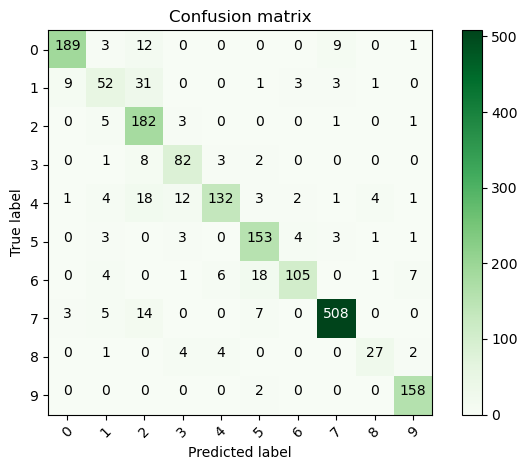

In [34]:
print(classification_report(test_labs, predicted_classes))
plot_confusion_matrix(confusion_matrix(test_labs, predicted_classes), classes=range(10))
display(class_names)

The performance here is already significantly better than the SVMs, although this could just be because the input dataset is much larger. The results are still very mixed, with the results for Early Blight much worse than all of the other categories for both precision and recall. The results for healthy images are the best performing, which would be a useful feature for real world implementation.

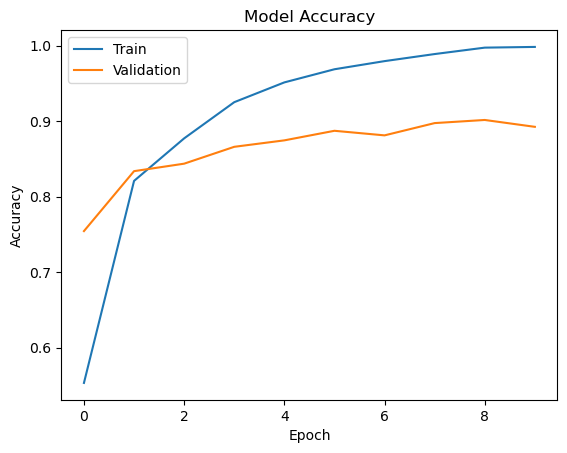

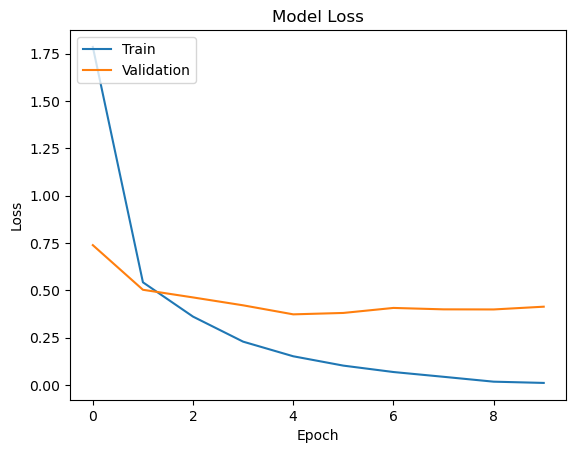

In [35]:
# Accuracy
eval_plot(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

# Loss
eval_plot(history.history['loss'], history.history['val_loss'], 'Loss')

From these graphs, it is clear that the model begins to significantly overfit to the training data within a couple of epochs.

### Hyperparameter training

The parameters selected for the first model are not necessarily optimal. Here hyperparameter tuning can be carried out for the size of some of the layers and the amount of drop out. This is just some of the hyperparameters that could be examined, as the number of layers is not varied here.

First the subset of data is loaded in for training and validation. Unlike with SVMs, the order is shuffled so that the CNN doesn't learn an order to the categories. As the data is loaded in directly rather than using a generator, the labels also need to be one hot encoded.

In [36]:
# Load the data without flattening
def cnn_load(folder_name):
    images = []
    labels = []
    dir_list = next(os.walk('./'+folder_name))[1]
    
    for folder in dir_list:
        img_list = next(os.walk('./'+folder_name+'/'+folder+'/'))[2]
        
        for image in img_list:
            img = load_img('./'+folder_name+'/'+folder+'/'+image, target_size=(256, 256,3))
            img = img_to_array(img)
            img = img/255
            images.append(img)
            labels.append(folder)
            
    return(images, labels)

# For a CNN, want to randomly shuffle the data
def shuffle_data(data_list, label_list):
    order = list(range(len(data_list)))
    random.shuffle(order)
    output_data = []
    output_labs = []
    for i in order:
        output_data.append(data_list[i])
        output_labs.append(label_list[i])
    return np.array(output_data), output_labs

train_data_cnn, train_labels_cnn = cnn_load('./subset/train')
valid_data_cnn, valid_labels_cnn = cnn_load('./subset/val')

train_data_cnn2, train_labels_cnn2 = shuffle_data(train_data_cnn, train_labels_cnn)
valid_data_cnn2, valid_labels_cnn2 = shuffle_data(valid_data_cnn, valid_labels_cnn)

In [37]:
train_labels_cnn2b = np.asarray(train_labels_cnn2).reshape(-1, 1)
valid_labels_cnn2b = np.asarray(valid_labels_cnn2).reshape(-1, 1)

oh_enc = OneHotEncoder(sparse_output=False)

train_labels_cnn2c = oh_enc.fit_transform(train_labels_cnn2b)
valid_labels_cnn2c = oh_enc.transform(valid_labels_cnn2b)

Now a model is built for using with Keras Tuner. The hyperparameters that should be varied are all specified with ranges of possible values. This is used with a random search and just 10 epochs so that the code runs in a reasonable amount of time.

In [38]:
def build_model(hp):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters=hp.Int('conv_1_filters', min_value=16, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
        activation = "relu" , input_shape = ((256, 256, 3)), padding='same') ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(
        filters=hp.Int('conv_2_filters', min_value=16, max_value=128, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values=[3,5]),
        activation = "relu", padding='same'),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=16, max_value=128, step=16),
        activation="relu"),
    tf.keras.layers.Dropout(
        rate=hp.Choice('dropout_1_rate', values=[0.1,0.3,0.5])),
    tf.keras.layers.Dense(
        units=hp.Int('dense_2_units', min_value=16, max_value=128, step=16),
        activation="relu"),
    tf.keras.layers.Dropout(
        rate=hp.Choice('dropout_2_rate', values=[0.1,0.3,0.5])),
    tf.keras.layers.Dense(10,activation = "softmax")])
    
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [39]:
tuner_search = keras_tuner.RandomSearch(build_model,
                                       objective='val_loss',
                                       max_trials=10,
                                       directory = ".",
                                       project_name="cnn_param_tune",
                                       overwrite=True)

tuner_search.search(train_data_cnn2, train_labels_cnn2c, epochs=10, validation_data=(valid_data_cnn2, valid_labels_cnn2c))


Trial 10 Complete [00h 19m 37s]
val_loss: 1.500794768333435

Best val_loss So Far: 1.0728150606155396
Total elapsed time: 02h 45m 58s
INFO:tensorflow:Oracle triggered exit


In [40]:
tuner_search.results_summary(1)

Results summary
Results in ./cnn_param_tune
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 01 summary
Hyperparameters:
conv_1_filters: 48
conv_1_kernel: 3
conv_2_filters: 128
conv_2_kernel: 3
dense_1_units: 96
dropout_1_rate: 0.1
dense_2_units: 96
dropout_2_rate: 0.3
Score: 1.0728150606155396


The best model found can now be tested on the test data. This will perform worse than the first CNN because it is trained on much less data.

In [41]:
best_model = tuner_search.get_best_models(num_models=1)[0]

In [42]:
# Generate predictions
test_generator.reset()
predict = best_model.predict(x=test_generator)
predicted_classes = np.argmax(predict,axis=1)

# Getting the correct labels
test_labs = test_generator.classes

# Getting original label names
class_indices = test_generator.class_indices
class_names = {}
for key, value in class_indices.items():
    class_names[key.replace("Tomato___", "")] = value

73/73 [==============================] - 39s 538ms/step


              precision    recall  f1-score   support

           0       0.64      0.86      0.73       214
           1       0.22      0.07      0.11       100
           2       0.55      0.66      0.60       192
           3       0.46      0.27      0.34        96
           4       0.57      0.40      0.47       178
           5       0.79      0.48      0.60       168
           6       0.49      0.56      0.52       142
           7       0.86      0.93      0.89       537
           8       0.52      0.32      0.39        38
           9       0.56      0.79      0.65       160

    accuracy                           0.66      1825
   macro avg       0.57      0.53      0.53      1825
weighted avg       0.65      0.66      0.64      1825



{'Bacterial_spot': 0,
 'Early_blight': 1,
 'Late_blight': 2,
 'Leaf_Mold': 3,
 'Septoria_leaf_spot': 4,
 'Spider_mites Two-spotted_spider_mite': 5,
 'Target_Spot': 6,
 'Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato_mosaic_virus': 8,
 'healthy': 9}

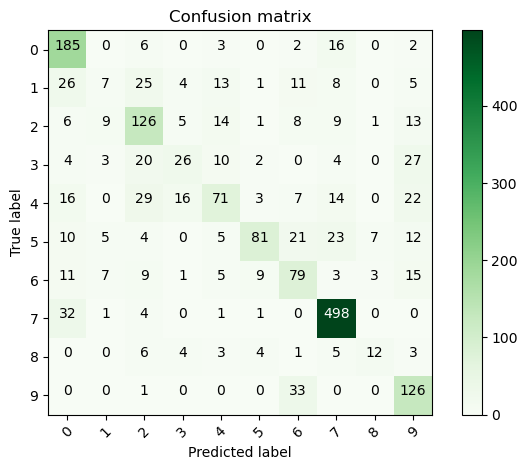

In [43]:
print(classification_report(test_labs, predicted_classes))
plot_confusion_matrix(confusion_matrix(test_labs, predicted_classes), classes=range(10))
display(class_names)

The performance here is only marginally better than the SVMs trained on the same data. 

### Optimised CNN

The parameters from this 'best model' can now be used on the full dataset and the results compared to the first CNN. Given the low number of epochs the models were trained on and the reduced dataset, it is possible that this model is one that trains fairly well quickly, rather than actually being the best if there were more epochs given for training as others might continue to improve for longer.

In [44]:
model = build_model(tuner_search.get_best_hyperparameters(1)[0])

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 256, 256, 48)      1344      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 48)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     55424     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 524288)            0         
                                                                 
 dense_3 (Dense)             (None, 96)               

In [46]:
train_step=train_generator.n//train_generator.batch_size
valid_step=valid_generator.n//valid_generator.batch_size

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)
history = model.fit(x=train_generator, epochs=20, verbose=1, steps_per_epoch=train_step,
                    validation_data=valid_generator, callbacks=[callback], validation_steps=valid_step)


Epoch 1/20
131/131 [==============================] - 1226s 9s/step - loss: 1.7927 - accuracy: 0.5188 - val_loss: 0.7734 - val_accuracy: 0.7448
Epoch 2/20
131/131 [==============================] - 1220s 9s/step - loss: 0.6781 - accuracy: 0.7760 - val_loss: 0.4381 - val_accuracy: 0.8572
Epoch 3/20
131/131 [==============================] - 1273s 10s/step - loss: 0.4244 - accuracy: 0.8600 - val_loss: 0.4543 - val_accuracy: 0.8561
Epoch 4/20
131/131 [==============================] - 1277s 10s/step - loss: 0.2930 - accuracy: 0.9030 - val_loss: 0.4391 - val_accuracy: 0.8619
Epoch 5/20
131/131 [==============================] - 1241s 9s/step - loss: 0.1963 - accuracy: 0.9348 - val_loss: 0.3179 - val_accuracy: 0.9079
Epoch 6/20
131/131 [==============================] - 1239s 9s/step - loss: 0.1390 - accuracy: 0.9544 - val_loss: 0.3900 - val_accuracy: 0.8840
Epoch 7/20
131/131 [==============================] - 1248s 10s/step - loss: 0.1098 - accuracy: 0.9647 - val_loss: 0.4276 - val_accura

In [47]:
model.save("models/model_tune_20.h5")

In [52]:
model = load_model("models/model_tune_20.h5")

In [53]:
# Generate predictions
test_generator.reset()
predict = model.predict(x=test_generator)
predicted_classes = np.argmax(predict,axis=1)

73/73 [==============================] - 31s 421ms/step


              precision    recall  f1-score   support

           0       0.91      0.93      0.92       214
           1       0.82      0.66      0.73       100
           2       0.86      0.88      0.87       192
           3       0.88      0.86      0.87        96
           4       0.89      0.87      0.88       178
           5       0.89      0.93      0.91       168
           6       0.92      0.87      0.90       142
           7       0.96      0.99      0.97       537
           8       0.88      0.79      0.83        38
           9       0.98      1.00      0.99       160

    accuracy                           0.92      1825
   macro avg       0.90      0.88      0.89      1825
weighted avg       0.91      0.92      0.91      1825



{'Bacterial_spot': 0,
 'Early_blight': 1,
 'Late_blight': 2,
 'Leaf_Mold': 3,
 'Septoria_leaf_spot': 4,
 'Spider_mites Two-spotted_spider_mite': 5,
 'Target_Spot': 6,
 'Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato_mosaic_virus': 8,
 'healthy': 9}

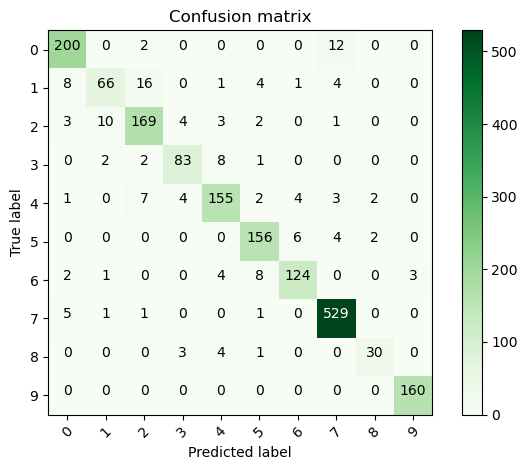

In [54]:
print(classification_report(test_labs, predicted_classes))
plot_confusion_matrix(confusion_matrix(test_labs, predicted_classes), classes=range(10))
display(class_names)

This model is performing slightly better than the original basic CNN, with 92% accuracy rather than 87%. The learning time was about 6 times longer. Early Blight and Late Blight are those most often confused with each other, which is unsurprising given their names. 

If the model was only used as a binary classifier between healthy or not then it is performing very well. All healthy plants were classified as such and only 3 were wrongly classified as healthy.

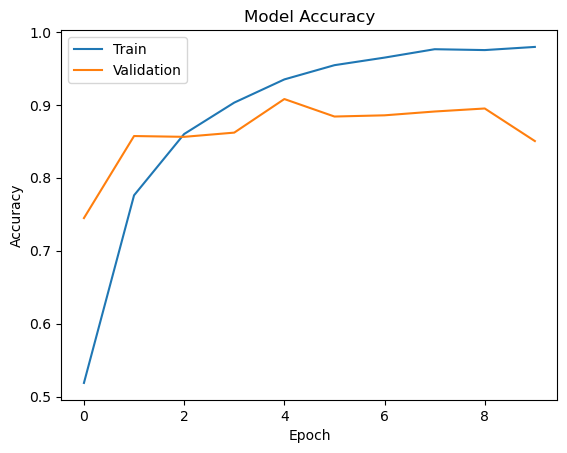

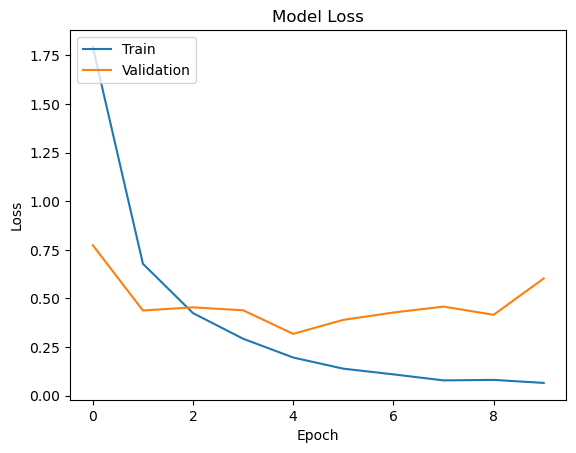

In [51]:
# Accuracy
eval_plot(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

# Loss
eval_plot(history.history['loss'], history.history['val_loss'], 'Loss')

The shape of these graphs is similar to those produced for the original CNN. There is certainly room for improving it further. The results for the training set improve much further than for the validation set, and the test set. This could be improved by augmenting the training and validation data, especially for the categories with very little data. The recall for Early Blight is much worse than for the other categories, and it is the 3rd smallest category.

<a id='summary'></a>
## Summary
[Back to contents](#contents)

The original study the data was prepared for achieved significantly better results than found here. Although they were further including data for other plants, they achieved 96.46% classification accuracy. They used a deeper CNN with nine layers. As a result they could use higher levels of drop out and a lower learning rate to avoid overfitting. Furthermore, they found increased performance when using augmentation on the dataset.

The following may all bring further improvements to these results:
- Augmenting the training and validation images.
- Running the model multiple times and combining the results
- Hyperparamater tuning on a larger dataset
- Experimenting with different numbers of layers in the CNN
- Hyperparameter tuning with a wider range of values

The final results may not be as good as the paper, but they are a significant improvement on the initial models. The SVMs were hampered by their computational demands resulting in only the data subset being implemented and would likely have capacity for easy improvements.